# Модель прогнозирования стоимости жилья для агентства недвижимости

- Работа с признаками
    - ['target'](#target )
    - ['city'](#city)
    - ['private pool' и 'PrivatePool'](#pool)
    - ['sqft'](#sqft)
    - ['beds'](#beds)
    - ['stories'](#stories)
    - ['homeFacts'](#homeFacts)
        - ['Year built' и 'Remodeled year'](#уеаr)
        - ['lotsize'](#lotsize)
        - ['sqftPrice'](#sqftPrice)
    - ['propertyType'](#propertyType)
    - ['status'](#status)
- [подготовка данных](#prepData)
- [создание моделей](#model)
    - [SGDRegressor](#SGDRegressor)
        - нормализация признаков RobustScaler
        - обучение модели
    - [RandomForestRegressor](#RandomForestRegressor)
        - обучение модели
    - [GradientBoostingRegressor ( лучший результат )](#GradientBoostingRegressor)
        - подбор гиперпараметров
        - обучение модели

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

np.set_printoptions(suppress = True, precision = 2)

### Удалим дубликаты

In [2]:
data = pd.read_csv('data-2.csv')

# удаляем дупликаты ----
a = data.shape[0]
data.drop_duplicates(ignore_index = True,inplace = True)
print('дупликатов :',a - data.shape[0])

data.info()

дупликатов : 50
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377135 entries, 0 to 377134
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337218 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342402 non-null  object
 3   street        377133 non-null  object
 4   baths         270827 non-null  object
 5   homeFacts     377135 non-null  object
 6   fireplace     103112 non-null  object
 7   city          377101 non-null  object
 8   schools       377135 non-null  object
 9   sqft          336585 non-null  object
 10  zipcode       377135 non-null  object
 11  beds          285881 non-null  object
 12  state         377135 non-null  object
 13  stories       226462 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40310 non-null   object
 16  MlsId         310266 non-null  object
 17  target        374655 non-null  object
dtypes: objec

#### функции, которые потребуются

In [3]:
# заменить подстроку ------- 
def replace_substring( column, to_delete, to_paste ):
    func = lambda x: x.replace(to_delete,to_paste) if pd.notna(x) else x
    data[column] = data[column].apply(func)

# заменить значение, если оно совпадает с указанным  ----
def replace_string( column, what, to_paste ):
    func = lambda x: x if pd.isna(x) else to_paste if x == what else x
    data[column] = data[column].apply(func)    

# заменить значение, если найдена указанная подстрока  ----
def replace_if_found( column, to_find, to_paste ):
    func = lambda x: x if pd.isna(x) else to_paste if x.find(to_find) != -1 else x
    data[column] = data[column].apply(func)

# убирает из строки все символы, кроме точки и цифр ------------
decimalSimbols = ['0','1','2','3','4','5','6','7','8','9','.']
def onlyDecimal(str):
    if pd.isnull(str):
        return np.nan;
    result = "".join(c for c in str if c in decimalSimbols)
    if result == '':
        result = np.nan
    return result

#--- строим графики для параметра. ------------------------
#--- boxplot, гисторамму и scatter в сравнении с ценой. --
def paramPlot(col):
    plt.figure(figsize=(14, 3)) # Вывод графиков 
    plt.subplot(1,3, 1)
    plt.boxplot(x = col)
    plt.subplot(1,3, 2)
    plt.hist( col )
    plt.subplot(1,3, 3)
    plt.scatter(x=col, y=data.target, color='#997733', alpha = 0.2)
    plt.show()

#----   график корреляции признаков. ------------
def corBar(column,h,title):
    dd = data[column].corr()['target'].sort_values(ascending = True)
    plt.figure(figsize=(6, h))
    dd.drop('target').plot(kind = "barh",title = title, grid=True)

----
<a id = "target"></a>
## 'target'
#### удаляем строки, где нет цены (целевого значения)
Много строк без цены, удалим эти строки    

также препреобразуем значение в колонке **target** из строки в число

In [4]:
data.dropna( subset = ['target'], inplace = True )
data.reset_index(drop = True, inplace = True )
data['target'] = data['target'].apply(onlyDecimal).astype(float)

----
<a id = "city"></a>
## 'city'
Попробуем создать новый признак с *"популярностью"* города.     
Так как городов слишком много, то оставим только самые популярные города, остальным присвоим значение *"other"*.     
Это позволит использовать **OneHot Encoding**

- Cделаем все символы строчными, что бы не было дубликатов    
- Создадим отдельную колонку с "популярностью" города
- Оставим только самый частые города, остальным присвоим значение *"other"*

In [5]:
# убираем повторения. -----------
print( "было уникальных значений :", data.city.nunique() )
data.city = data.city.str.lower()
print( "стало уникальных значений :", data.city.nunique() )

было уникальных значений : 2019
стало уникальных значений : 1904


In [6]:
temp = pd.DataFrame( data.city.value_counts() )
temp.reset_index(inplace= True )
temp.rename({'city':'city_popularity', 'index':'city'}, axis = 1, inplace= True)
data = pd.merge(data,temp, on = 'city', how = 'left') # how = 'left'

# оставим только название популярных городов ------
def func(row):
    if( row['city_popularity']>1000 ):
        return row['city']
    else:
        return 'other'
    
data['city'] = data.apply(func, axis = 1) 
print('всего уникальных названий :', data['city'].nunique())

всего уникальных названий : 69


----
<a id = "pool"></a>

## 'private pool' и 'PrivatePool'
Означают присутсвие бассейна.
Бассейн может быть отмечен только в одной из двух колонок, что можно проверить кодом    
```python
data[ (~data['private pool'].isna()) & (~data['PrivatePool'].isna())]
```
Объединим их в одну колонку ***"pool"***
- **0** нет бассейна
- **1** есть бассейн

In [7]:
# приведём колонки к виду 0 - нет бассейна, 1 - есть бассейн.  
data['PrivatePool' ] = data['PrivatePool' ].apply( lambda x: 0 if pd.isnull(x) else 1)
data['private pool'] = data['private pool'].apply( lambda x: 0 if pd.isnull(x) else 1)

# создаём колонку 'pool'
data['pool'] = data['PrivatePool'] + data['private pool']

# удаляем ненужные колонки -------------
data.drop(['PrivatePool','private pool'], axis = 1, inplace=True)

----
<a id = "sqft"></a>
## 'sqft'
всего есть 25405 вариантов
Преобразуем колонку в числовую
- уберём все символы кроме цифр, если **nan**, то не трогаем
- если пустая строка, то заменим на **nan**

In [8]:
data['sqft'] = data['sqft'].apply(onlyDecimal).astype(float)

####  удалим выбросы и посмотрим на графики

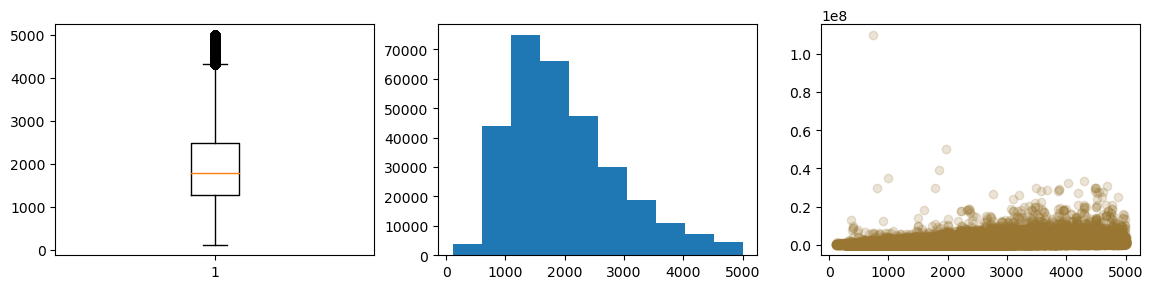

In [9]:
# выбросы
data = data[ (data.sqft > 100) &  (data.sqft < 5000)].reset_index(drop = True)
paramPlot(data.sqft)

----
<a id = "beds"></a>
## 'beds'
Здесь нельзя удалить все буквы и оставить только цифры, так как часто встречаются  значения не соответствующие колонке.    
Например, включают слова или отдельные записи без чисел 
- *'...sqft'* - 1372 записей
- *'...acre'* - 1602 записей
- *'Baths'* 15258 записей
- *'Bath'*  737 записей

Присвою им значение **nan**

---
Обработаю строки, которые включает строку:
- *'2 Bedrooms'* 4 записей
- *'3 or More Bedrooms'* 4 записей

In [10]:
replace_if_found(  'beds', 'sqft' , np.nan )
replace_if_found(  'beds', 'acre' , np.nan )
replace_string(    'beds', 'Baths', np.nan )
replace_string(    'beds', 'Bath' , np.nan )
replace_if_found(  'beds', 'Based', np.nan )
replace_string(    'beds', '# Bedrooms 1st Floor' , np.nan )

# преобразую колонку в числовую
data.beds = data.beds.apply(onlyDecimal).astype(float)

####  удалим выбросы и посмотрим на графики

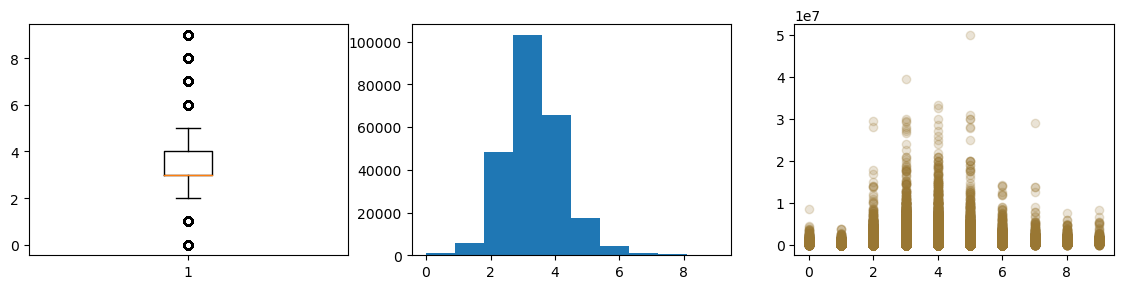

In [11]:
data = data[data.beds < 10].reset_index(drop = True)
paramPlot(data.beds)

----
<a id = "stories"></a>
## 'stories'

332 уникальных вариантов.     
Удалим некорректные варианты и попробуем привести признак в числовой вид.

In [12]:
replace_string( 'stories', 'One and One Half, Three Or More' , np.nan )
replace_string( 'stories', 'One, Three Or More'              , np.nan)
replace_string( 'stories', '1.75'                            , np.nan)
replace_string( 'stories', '1.70'                            , np.nan)
replace_string( 'stories', '1.7000'                          , np.nan)
replace_string( 'stories', '1.3000'                          , np.nan)
replace_string( 'stories', '2.20'                            , np.nan)
replace_string( 'stories', '1.30'                            , np.nan)
replace_string( 'stories', 'Townhouse-2 Story, T3-Townhouse 3+ Stories' , np.nan)


replace_string( 'stories', 'One and One Half'      , '1')
replace_string( 'stories', 'One, Two'              , '2')
replace_string( 'stories', 'One, Two, Multi/Split' , '2')


replace_if_found('stories', 'One'   , '1')
replace_if_found('stories', 'Two'   , '2')
replace_if_found('stories', 'Three' , '3')

replace_string( 'stories', '1 Story/F.R.O.G.'        , '1')
replace_string( 'stories', 'Townhouse'               , '2')
replace_string( 'stories', 'Traditional'             , '1')
replace_string( 'stories', 'Ranch'                   , '1')
replace_string( 'stories', 'Raised Ranch'            , '2')
replace_string( 'stories', 'Tri-Level'               , '3')
replace_string( 'stories', '1 1/2 Levels'            , '1')
replace_string( 'stories', 'Modular Home'            , '1')
replace_string( 'stories', 'Farm House'              , '1')
replace_string( 'stories', 'Fourplex'                , '2')
replace_string( 'stories', 'Mobile'                  , '1')
replace_string( 'stories', 'Cabin/Cottage'           , '1')
replace_string( 'stories', 'Split Entry (Bi-Level)'  , '2')
replace_string( 'stories', 'Bungalow'                , '2')
replace_string( 'stories', 'Victorian'               , '2')
replace_string( 'stories', 'Bi-Level'                , '2')
replace_string( 'stories', '3 - 5 Stories'           , '4')
replace_string( 'stories', '1.5, 2'                  , '2')
replace_string( 'stories', 'Tri Level'               , '3')
replace_string( 'stories', 'Tri/Multi Level'         , '3')
replace_string( 'stories', '2 Story or 2 Level'      , '2')
replace_string( 'stories', 'Quad Level'              , '4')
replace_string( 'stories', 'T3-Townhouse 3+ Stories' , '3')
replace_string( 'stories', '3.5'                     , '3')

replace_substring( 'stories', '1.5'                  , '1')
replace_substring( 'stories', '2.5'                  , '2')


In [13]:
# преобразую колонку в числовую
data.stories = data.stories.apply(onlyDecimal).astype(float)

print( 'количество значений NaN :', data[ (data['stories'].isna()) ].shape[0] )
print( '        больше 4 этажей :', data[ (data['stories'] > 4) ].shape[0]    )
print( '            ноль этажей :', data[ (data['stories'] == 0) ].shape[0]   )

количество значений NaN : 59455
        больше 4 этажей : 5880
            ноль этажей : 10659


Слишком много значений NaN и выбросов,     
поэтому преобразуем этот параметр с помощью **one hot encoding**,     
используя значения     
*('unknown', '1', '2', '3', '4')*

In [14]:
def temp(x):
    if   x == 1: return '1'
    elif x == 2: return '2'
    elif x == 3: return '3'    
    elif x == 4: return '4'
    else: return 'unknown'
data['stories'] = data['stories'].apply( temp )


data.stories.value_counts()

1          86603
unknown    75994
2          68769
3          13719
4           2305
Name: stories, dtype: int64

In [15]:
data.shape

(247390, 18)

----
<a id = "homeFacts"></a>
## 'homeFacts'

колонка **homeFacts** не имеет пропусков и имеет подобный вид в виде строки, представляющий из себя словарь:

sample 0   (```dt.homeFacts[0]```)

```
'atAGlanceFacts': [
{'factValue':                   '2019', 'factLabel': 'Year built'    }, 
{'factValue':                       '', 'factLabel': 'Remodeled year'}, 
{'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'       }, 
{'factValue':                       '', 'factLabel': 'Cooling'       }, 
{'factValue':                       '', 'factLabel': 'Parking'       }, 
{'factValue':                     None, 'factLabel': 'lotsize'       }, 
{'factValue':                   '$144', 'factLabel': 'Price/sqft'    }   ]  
```

- Уберём всё лишнее, оставим только значения и в качестве разделителя будем использовать *";"*
- создадим 7 новых колонок

In [16]:
# определим функцию, которую применим к столбцу  -------------------
def deser(q):
    q = q.replace("{'atAGlanceFacts': [{'factValue': "               , '' )
    q = q.replace(", 'factLabel': 'Year built'}, {'factValue': "     , ';' )
    q = q.replace(", 'factLabel': 'Remodeled year'}, {'factValue': " , ';' )
    q = q.replace(", 'factLabel': 'Heating'}, {'factValue': "        , ';' )
    q = q.replace(", 'factLabel': 'Cooling'}, {'factValue': "        , ';' )
    q = q.replace(", 'factLabel': 'Parking'}, {'factValue': "        , ';' )
    q = q.replace(", 'factLabel': 'lotsize'}, {'factValue': "        , ';' )
    q = q.replace(", 'factLabel': 'Price/sqft'}]}"                   , '' ) 
    return q
    
#  применяем функцию  -----------------------------------------------
data.homeFacts = data.homeFacts.apply( deser )

data['year']           = data.homeFacts.apply( lambda x: x.split(';')[0] )
data['year_remod']     = data.homeFacts.apply( lambda x: x.split(';')[1] )
data['heating']        = data.homeFacts.apply( lambda x: x.split(';')[2] )
data['cooling']        = data.homeFacts.apply( lambda x: x.split(';')[3] )
data['parking']        = data.homeFacts.apply( lambda x: x.split(';')[4] )
data['lotsize']        = data.homeFacts.apply( lambda x: x.split(';')[5] )
data['sqftPrice']      = data.homeFacts.apply( lambda x: x.split(';')[6] )

data.drop(['homeFacts'], axis = 1, inplace=True)

У нас появилось 7 новых колонок, которые также требуют предобработки
- year
- year_remod
- heating
- cooling
- parking
- lotsize
- sqftPrice

----
<a id = "уеаr"></a>
###  Дата постройки и капитального ремонта

Мы создали две временные колонки
- 'year' - дата постройки
- 'year_remod' - дата ремонта

1. Удалим несколько ошибочных данных и преобразуем колонки в числовую
2. Вычтем год постройки из текущего года, получим возраст дома
3. Вычтем год ремонта из текущего года, получим срок после ремонта
    - Если год ремонта = nan, то присвоим возраст дома
    - Если год ремонта < года постройки, то присвоим возраст дома

### 'year'

In [17]:
# удалим несколько ошибочных данных ----------

replace_string( 'year',  "''"             , np.nan )
replace_string( 'year',  "None"           , np.nan )
replace_string( 'year',  "'No Data'"      , np.nan )
replace_string( 'year',  "'559990649990'" , np.nan )
replace_string( 'year',  "'1'"            , np.nan )

In [18]:
# преобразую колонку в числовую
data['year'] = data['year'].apply(onlyDecimal).astype(float)

### 'year_remod'

In [19]:
replace_string( 'year_remod',  "''"             , np.nan )
replace_string( 'year_remod',  "None"           , np.nan )
replace_string( 'year_remod',  "'0'"            , np.nan )

In [20]:
# преобразую колонку в числовую
data['year_remod'] = data['year_remod'].apply(onlyDecimal).astype(float)

У нас получается странная картина.    
В большинстве случаев капремонт был в тот же год, что и постройка.   
В некоторых случаев капремонт был даже до постройки дома 

In [21]:
data[data['year'] > data['year_remod']][['year','year_remod']].sample(8).T

,141137,247089,21812,163514,222268,226352,82569,109627
year,1997.0,2007.0,2018.0,1955.0,2019.0,2019.0,2018.0,2019.0
year_remod,1996.0,1940.0,1900.0,1953.0,1951.0,2016.0,1951.0,1965.0


### окончательное преобразование 
Если год ремонта не указан или был до постройки, то укажем год построки

Затем создадим колонки:
- **age** - возраст дома
- **age2** - время, прошедшее после ремонта.

Колонки с датами удалим

In [22]:
def yearFunc(row):
    if pd.isna( row['year'] ):
        return np.nan
    elif row['year'] > 2023:
        return 0;
    else:
        return 2023 - row['year']

data['age'] = data.apply( yearFunc, axis = 1 )    
    
def yearFunc2(row):
    if pd.isna( row['year'] ):
        return np.nan
    elif pd.isna( row['year_remod'] ):
        return row['age']
    elif row['year_remod'] < row['year']:
        return row['age']
    else:
        return 2023 - row['year_remod'] 
    
data['age2'] = data.apply( yearFunc2, axis = 1 )

data.drop(['year','year_remod'], axis = 1, inplace=True)

####  удалим выбросы и посмотрим на графики

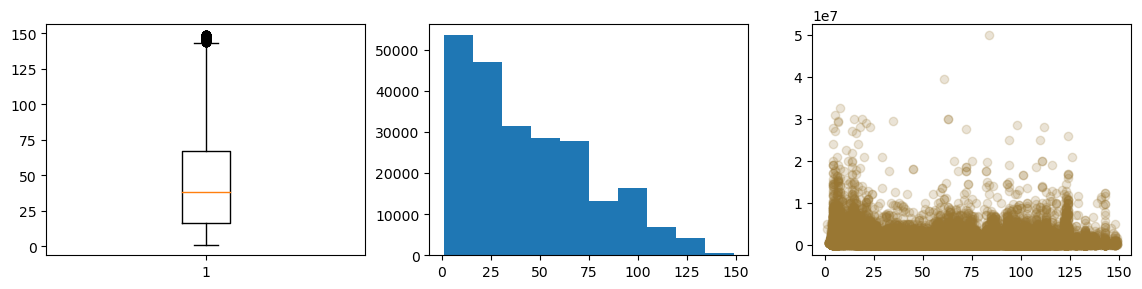

In [23]:
data = data[ data.age < 150 ].reset_index(drop = True)
paramPlot(data.age)

----
<a id = "lotsize"></a>
##  'lotsize'
В колонке встречаются размер как в квадратных футах, так и в акрах.    
Создадим временную колонку, имеющую три варианта значений
- **not** в колонке *'lotsize'* нет размера
- **sqft** в колонке *'lotsize'* размер в квадратных футах
- **acre** в колонке *'lotsize'* размер в акрах

Преобразуем  колонку 'lotsize' и конвертируем  данные, которые были данны в акрах в квадратные футы

In [24]:
# убирает из строки все цифры ------------
simb = ['0','1','2','3','4','5','6','7','8','9',"'"]
def notDecimal(str):
    return "".join( c for c in str if c not in simb )

replace_substring( 'lotsize', '-', '' )
data.lotsize = data.lotsize.apply( lambda x: 'None' if x == "''" else x)

data['temp'] = data.lotsize.apply(notDecimal)
data.temp = data.temp.str.lower()

print('всего уникальных значений во временной колонке :', data['temp'].nunique())
data['temp'].unique()

всего уникальных значений во временной колонке : 18


array(['none', ' sqft', ', sqft', '', '. acres', ', sqft lot',
       '. acres lot', 'no data', ' sqft lot', ' acres', ' acre lot',
       ' acre', ',. acres', ' acres lot', ', acres', ', acres lot',
       ',. acres lot', ' property will be on the right. parking'],
      dtype=object)

Теперь доведём количество уникальных значений до трёх:    
- **not** 
- **acre** 
- **sqft**

In [25]:
replace_if_found( 'temp', 'acre', 'acre' )
replace_if_found( 'temp', 'sqft', 'sqft' )
replace_string(   'temp',  ''   , 'sqft' )

func = lambda x: 'not' if x not in ['sqft', 'acre'] else x
data['temp'] = data['temp'].apply(func)

print('всего уникальных значений :', data['temp'].unique())

всего уникальных значений : ['not' 'sqft' 'acre']


Уберём из *'lotsize'* все не числа и переведём его в формат **float**

In [26]:
def func(row):
    if row['temp'] == 'not':
        return '0'
    else:
        return onlyDecimal( row['lotsize'] )

data['lotsize'] = data.apply(func, axis = 1)

# переводим в float
data['lotsize'] = data['lotsize'].astype(float)

#### Конвертируем акры в квадратные футы

In [27]:
def func(row):
    if row['temp'] == 'acre':
        return row['lotsize']*43560
    else:
        return row['lotsize']

data['lotsize'] = data.apply(func, axis = 1)

# удаляем временную колонку ----------
data.drop('temp', axis = 1, inplace=True)

####  удалим выбросы и посмотрим на графики

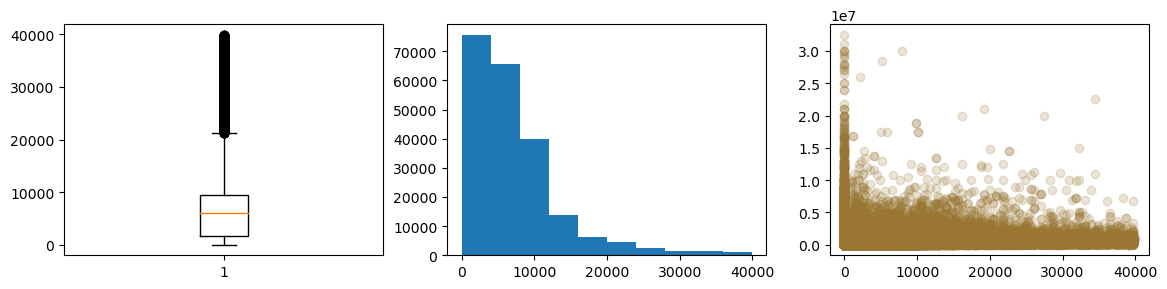

In [28]:
data = data[ data.lotsize < 40000 ].reset_index(drop = True)
paramPlot(data.lotsize)

----
<a id = "sqftPrice"></a>
##  'sqftPrice'
Этот признак представляет из себя **утечку данных**, так как позволяет напрямую с признаком *"sqft"* узнать цену.

Мы не будем использовать его при обучении, но воспользуемся, что бы удалить выбросы

In [29]:
data['sqftPrice'] = data['sqftPrice'].apply(onlyDecimal).astype(float)

####  удалим выбросы и посмотрим на графики

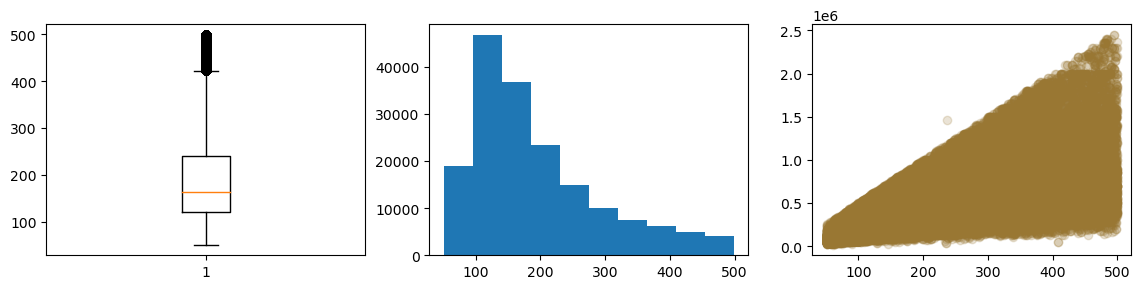

In [30]:
data = data[ (data.sqftPrice > 50) & (data.sqftPrice < 500) ]
paramPlot( data.sqftPrice )

----
<a id = "propertyType"></a>
##  'propertyType'
Объединим все синонимы, уменьшив количество уникальных вариантов

In [31]:
data.propertyType = data.propertyType.str.lower()
data.groupby(by='propertyType')['sqftPrice'].count()

propertyType
apartment                           95
condo                            20274
condo/townhome/row home/co-op     5594
coop                               319
cooperative                        179
farms/ranches                        1
lot/land                           754
mfd/mobile home                    449
miscellaneous                        4
mobile / manufactured              502
mobile/manufactured                773
multi family                      1404
multi-family                      3237
multi-family home                  522
single family                    41719
single family home               21707
single-family home               63938
townhouse                        12259
unknown                             10
Name: sqftPrice, dtype: int64

In [32]:
 # удалим одиночные и странные строки -------------
data = data[(data['propertyType'] != 'miscellaneous') &
            (data['propertyType'] != 'farms/ranches') & 
            (data['propertyType'] != 'unknown') ].reset_index(drop = True)

replace_if_found( 'propertyType', 'single', 'single_family' )
replace_if_found( 'propertyType', 'multi' , 'multi_family' ) 
replace_if_found( 'propertyType', 'mobile', 'mobile' ) 
replace_if_found( 'propertyType', 'coop'  , 'coop' ) 
replace_if_found( 'propertyType', 'condo' , 'condo' ) 

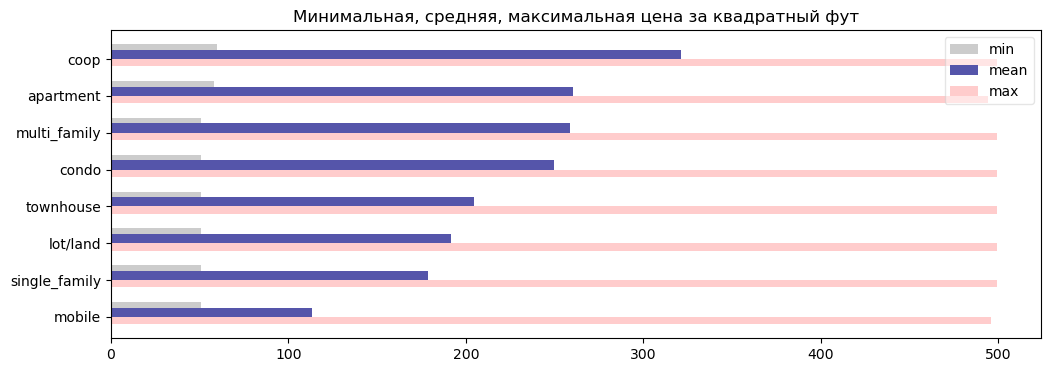

In [33]:
temp = data.groupby(by='propertyType')['sqftPrice'].agg(['min','mean','max'])
temp = temp.sort_values(by = 'mean',ascending = True)
plt.figure(figsize=(12, 4))
plt.barh(y = temp.index, width=temp['min'],  left = 0, align = 'edge', 
         height = 0.4,   color = '#cccccc',  label = 'min' )
plt.barh(y = temp.index, width=temp['mean'], left = 0, align = 'edge', 
         height = 0.25,  color = '#5555aa',  label = 'mean')
plt.barh(y = temp.index, width=temp['max'],  left = 0, align = 'edge', 
         height = -0.2, color = '#ffcccc',  label = 'max')

plt.legend(framealpha = 0.5 )
plt.title('Минимальнaя, средняя, максимальная цена за квадратный фут')
plt.show()

----
<a id = "status"></a>
##  'status'
Объединим все схожие варианты, уменьшив количество уникальных вариантов

In [34]:
data.dropna( subset = ['status'], inplace = True )
print( 'уникальных :', data.status.nunique() , ' всего строк:', data.shape[0] )
data.status = data.status.str.lower()  
data.status = data.status.str.replace('  ', ' ')
data.status = data.status.str.replace('  ', ' ')
print( 'уникальных :', data.status.nunique() )

уникальных : 110  всего строк: 149406
уникальных : 105


In [35]:
# объединим в одну группу все записи с  'coming soon' ----  
replace_if_found('status', 'coming soon' , 'Coming_Soon')

# объединим 'active', 'for sale' ----
replace_string('status', 'active'  , 'For_Sale' )
replace_string('status', 'for sale', 'For_Sale' )

#объединим 'foreclosed' и 'foreclosure' -----
replace_if_found('status', 'foreclos', 'Foreclosure')

# у 'a active' низкая цена, скорее всего это 'auction active' ----
replace_string('status', 'a active', 'Auction' )
replace_string('status', 'auction',  'Auction' )

# добавим столбец со встречаимостью данного статуса -----
temp = pd.DataFrame( data.status.value_counts() )
temp.reset_index(inplace= True )
temp.rename({'status':'status_popularity', 'index':'status'}, axis = 1, inplace= True)
data = pd.merge(data,temp, on = 'status', how = 'left')

# удаляем все строки с редкими статусами ------
data = data[data.status_popularity >20]
data.drop('status_popularity', axis = 1, inplace=True)

# под 'active under contract' высокие цены, оставим отдельно ----
replace_string('status', 'active under contract', 'Active_Under_Contract')

replace_string('status', 'contract p', 'Contract-p-pi-c')
replace_string('status', 'p'         , 'Contract-p-pi-c')
replace_string('status', 'pi'        , 'Contract-p-pi-c')
replace_string('status', 'c'         , 'Contract-p-pi-c')

# объединим в одну группу 'pending' ---------
replace_if_found('status','pending'          , 'Pending')
replace_string('status', 'active with offer', 'Pending')

# объединим те где предложение сделано, но продажа не состоялась ------
replace_if_found('status','under'   , 'Under_Contract')
replace_if_found('status','contract', 'Under_Contract')

# под 'contingent show' высокие цены, оставим отдельно ----
replace_string('status', 'contingent show','Сontingent_Show')

# объединим в одну группу 'contingent' ---------
replace_if_found('status','contingent'    , 'Сontingent')
replace_if_found('status','active backup' , 'Сontingent')

print('уникальных :' , data.status.nunique(),  '   всего строк:' , data.shape[0])

уникальных : 11    всего строк: 149247


In [36]:
q = data.groupby('status').agg({'sqftPrice': ['median','mean'], 'target': 'count'})
print( 'уникальных :', data.status.nunique() )
q

уникальных : 11


sqftPrice              target
                         median        mean   count
status                                             
Active_Under_Contract     370.0  345.459119     318
Auction                    94.0  123.063953     172
Coming_Soon               178.0  215.881720      93
Contract-p-pi-c           274.0  286.987490    1199
For_Sale                  162.0  191.937407  134936
Foreclosure               129.0  158.317183    3096
Pending                   130.0  151.686721    3690
Under_Contract            161.0  180.949576    2479
new construction          192.0  221.257657    2612
Сontingent                105.0  115.561020     549
Сontingent_Show           276.0  267.446602     103

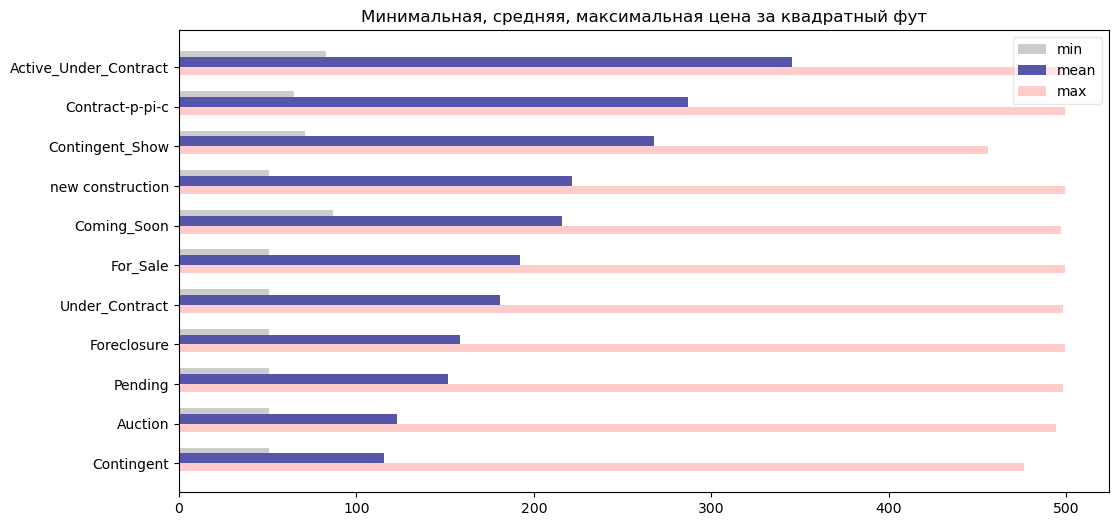

In [37]:
temp = data.groupby(by='status')['sqftPrice'].agg(['min','mean','max'])
temp = temp.sort_values(by = 'mean',ascending = True)
plt.figure(figsize=(12, 6))
plt.barh(y = temp.index, width=temp['min'],  left = 0, align = 'edge', 
         height = 0.4,   color = '#cccccc',  label = 'min' )
plt.barh(y = temp.index, width=temp['mean'], left = 0, align = 'edge', 
         height = 0.25,  color = '#5555aa',  label = 'mean')
plt.barh(y = temp.index, width=temp['max'],  left = 0, align = 'edge', 
         height = -0.2, color = '#ffcccc',  label = 'max')

plt.legend(framealpha = 0.5 )
plt.title('Минимальнaя, средняя, максимальная цена за квадратный фут')
plt.show()

In [38]:
data.reset_index(inplace= True , drop = True)

In [39]:
#data.to_pickle ("dataDlotsize.pkl")
#data = pd.read_pickle ("dataDlotsize.pkl")

------
---
---
<a id = "prepData"></a>
## Подготовка данных
#### Удалим колонки, которые не будем использовать

In [40]:
columnsToDelete = [ 'street', 'baths', 'fireplace', 'schools', 'mls-id', 'MlsId',  
                   'heating', 'cooling', 'parking']
data.drop( columnsToDelete, axis = 1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149247 entries, 0 to 149246
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   status           149247 non-null  object 
 1   propertyType     149247 non-null  object 
 2   city             149247 non-null  object 
 3   sqft             149247 non-null  float64
 4   zipcode          149247 non-null  object 
 5   beds             149247 non-null  float64
 6   state            149247 non-null  object 
 7   stories          149247 non-null  object 
 8   target           149247 non-null  float64
 9   city_popularity  149247 non-null  float64
 10  pool             149247 non-null  int64  
 11  lotsize          149247 non-null  float64
 12  sqftPrice        149247 non-null  float64
 13  age              149247 non-null  float64
 14  age2             149247 non-null  float64
dtypes: float64(8), int64(1), object(6)
memory usage: 17.1+ MB


### выполним кодирование некоторых признаков
One-hot encoding
 - status
 - propertyType
 - city
 - state
 - stories
 
 Binary encoder
 - zipcode

In [41]:
data = pd.get_dummies(data, columns = ['status'] )
data = pd.get_dummies(data, columns = ['propertyType'] )
data = pd.get_dummies(data, columns = ['city'] )
data = pd.get_dummies(data, columns = ['state'] )
data = pd.get_dummies(data, columns = ['stories'] )

In [42]:
import category_encoders as ce 
# кодируем zipcode  и присоединяем к датасету 
bin_encoder = ce.BinaryEncoder(cols=['zipcode']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['zipcode'])
data = pd.concat([data, type_bin], axis=1)
data.drop('zipcode', inplace = True, axis = 1)

In [43]:
data.shape

(149247, 148)

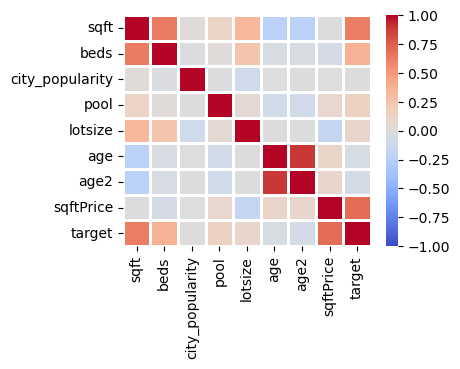

In [44]:
column = ['sqft', 'beds', 'city_popularity', 'pool', 'lotsize', 
          'age', 'age2' , 'sqftPrice', 'target']

plt.figure(figsize=(4, 3))
sns.heatmap(data[column].corr(), cmap= 'coolwarm',
            vmin=-1, vmax=1, center= 0, linewidths=1, linecolor='white')
plt.show()

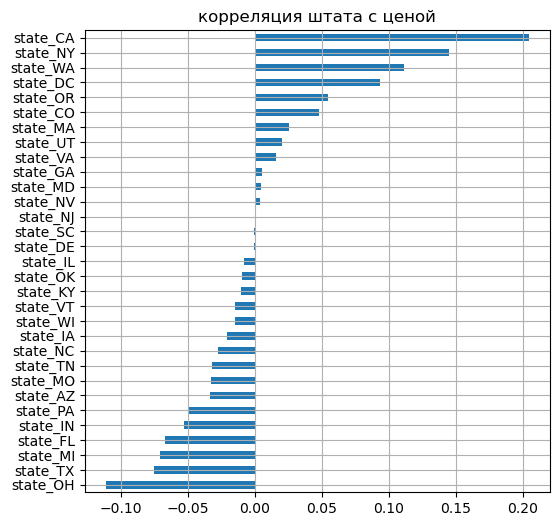

In [45]:
# колонки с именами штатов --------------
column1 = ['state_NC', 'state_WA', 'state_CA', 'state_TX', 'state_FL', 'state_PA', 
           'state_TN', 'state_IA', 'state_NY', 'state_MI', 'state_OR', 'state_OH', 
           'state_DC', 'state_VT', 'state_NV', 'state_AZ', 'state_UT', 'state_WI', 
           'state_KY', 'state_GA', 'state_OK', 'state_VA', 'state_IL', 'state_NJ', 
           'state_CO', 'state_MA', 'state_IN', 'state_MD', 'state_MO', 'state_SC', 
           'state_DE','target']
corBar(column1, 6, 'корреляция штата с ценой')

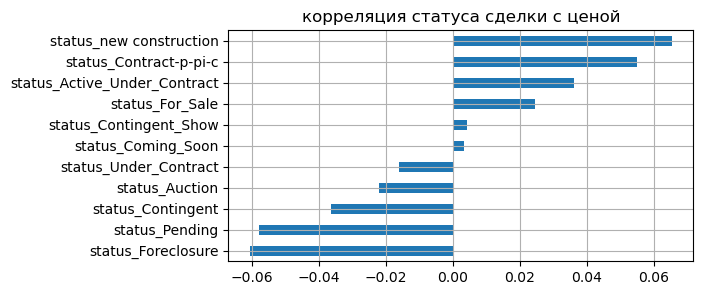

In [46]:
column2 = ['status_Active_Under_Contract', 'status_Auction', 'status_Coming_Soon', 
           'status_Contract-p-pi-c', 'status_For_Sale', 'status_Foreclosure', 
           'status_Pending', 'status_Under_Contract', 'status_new construction', 
           'status_Сontingent', 'status_Сontingent_Show','target']
corBar(column2, 3, 'корреляция статуса сделки с ценой')

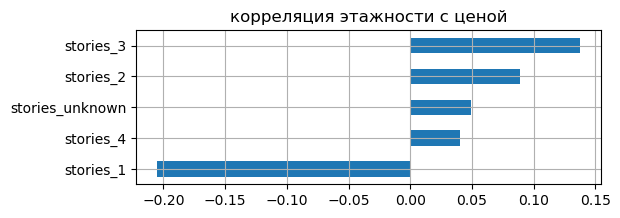

In [47]:
column3 = ['stories_1','stories_2','stories_3','stories_4', 'stories_unknown','target']
corBar(column3, 2, 'корреляция этажности с ценой')

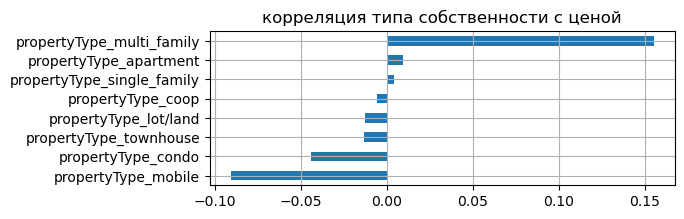

In [48]:
column4 = ['propertyType_coop', 'propertyType_apartment', 'propertyType_multi_family', 
           'propertyType_condo', 'propertyType_townhouse', 'propertyType_lot/land', 
           'propertyType_single_family', 'propertyType_mobile', 'target']
corBar(column4, 2, 'корреляция типа собственности с ценой')

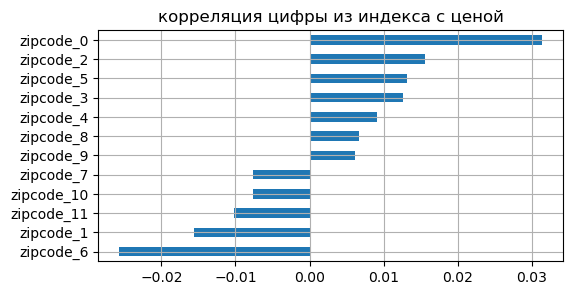

In [49]:
column5 = ['zipcode_0', 'zipcode_1', 'zipcode_2', 'zipcode_3', 'zipcode_4', 
           'zipcode_5', 'zipcode_6', 'zipcode_7', 'zipcode_8', 'zipcode_9', 
           'zipcode_10', 'zipcode_11', 'target']
corBar(column5, 3, 'корреляция цифры из индекса с ценой')

----
----

<a id = "model"></a>
## Создание моделей
Попробуем 3 модели
- SGDRegressor
- RandomForestRegressor
- GradientBoostingRegressor

#### разделение выборки на тренировочную и тестовую

In [50]:
data['target_log'] = np.log(data.target)
# все колонки.      ----------
X = data.drop(['target','target_log','sqftPrice'], axis=1) #матрица наблюдений
y = data['target']                                         #вектор правильных ответов
y_log = data['target_log'] 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, 
                                                    test_size=0.2, random_state=40)

----
<a id = "SGDRegressor"></a>
### SGDRegressor
Для этой модели надо нормализовать некоторые колонки.    
Воспользуемся методом **RobustScaler**

In [51]:
scaler = preprocessing.RobustScaler()

Xsc_train = X_train.copy()
Xsc_test  = X_test.copy()

columnToScale = ['sqft', 'beds', 'city_popularity', 'lotsize', 'age', 'age2']

scaler.fit(Xsc_train[columnToScale])

Xsc_train[columnToScale] = scaler.transform(X_train[columnToScale])
Xsc_test[ columnToScale] = scaler.transform(X_test[ columnToScale])

#### обучение модели

In [53]:
model = SGDRegressor(random_state=42)
%time model.fit(Xsc_train, y_train)
y_pred  = model.predict(Xsc_test)

print('RMSE score:', 
      round( mean_squared_error(y_test, y_pred, squared = False), 4 ))

CPU times: user 565 ms, sys: 76.2 ms, total: 641 ms
Wall time: 638 ms
RMSE score: 0.3667


----
<a id = "RandomForestRegressor"></a>
### RandomForestRegressor

#### обучение модели

In [54]:
RFG = RandomForestRegressor( n_estimators = 400, max_depth = None, random_state=42 )

%time RFG.fit(X_train, y_train)

y_pred = RFG.predict(X_test)

print('RMSE score:', 
      round( mean_squared_error(y_test, y_pred, squared = False), 4 ))

CPU times: user 9min 29s, sys: 2.78 s, total: 9min 32s
Wall time: 9min 32s
RMSE score: 0.2633


----
<a id = "GradientBoostingRegressor"></a>
### GradientBoostingRegressor ( лучший результат )

#### подбор гиперпараметров GridSearchCV

In [55]:
#------   сетка параметров  ---------------------------
param = {'learning_rate':[ 0.3, 0.5 ],
         'n_estimators': [ 300, 350 ],
         'max_depth': [ 10, 12, 14 ],
        }
#-----   инициализация GridSearchCV  ------------------
searchGBR = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42), 
    param_grid=param,                         # сетка параметров
    cv = 5,                                   # валидатор или число
    scoring = 'neg_root_mean_squared_error',  # метрика
    n_jobs = -1                               # греть комп
) 

#------  запускаем тесты по сетке параметров ----------
%time searchGBR.fit(X_train, y_train) 

# -----   считаем метрику(на test данных).  ------------
print( 'score :', searchGBR.score(X_test, y_test) )

searchGBR.best_params_

CPU times: user 4min 55s, sys: 1.03 s, total: 4min 56s
Wall time: 1h 13min 8s
score : -0.2248977524377633


{'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 350}

#### обучение модели

In [57]:
GBR = GradientBoostingRegressor(
    learning_rate     =   0.3,
    n_estimators      = 350, 
    max_depth         =  10,
    random_state=42 )

#Обучаем модель
%time GBR.fit(X_train, y_train)

y_test_pred = GBR.predict(X_test)

print('RMSE score:', 
      round( mean_squared_error(y_test, y_test_pred, squared = False), 4 ))

CPU times: user 4min 55s, sys: 576 ms, total: 4min 56s
Wall time: 4min 56s
RMSE score: 0.2249
